<a href="https://colab.research.google.com/github/Mindauskas/opencities/blob/master/OpenCities1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
   %tensorflow_version 2.x
except Exception:
   pass

TensorFlow 2.x selected.


In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
!mkdir -p /root/.kaggle
!cp ./kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [0]:
from pathlib import Path
import shutil
import kaggle
from glob import glob
import pandas as pd
import imageio
import os
import matplotlib.pyplot as plt
from PIL import Image as PImage
import numpy as np
import random
import imageio
import random_inspect
import plotting_utils
import split_df
import load_img
from load_img import read_imgs_from_df as read_imgs_from_df
import tensorflow as tf
import vanilla_unet
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Activation, 
    MaxPooling2D, Dropout, Conv2DTranspose,
    concatenate, Input
)
from tensorflow.keras.optimizers import Adam
import math
from google.colab import files
from datetime import date
import json
import tensorflow as tf
import imageio
from tqdm import tqdm_notebook
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_similarity_score

In [5]:
tf.__version__

'2.1.0'

In [6]:
!pip install tifffile

     |████████████████████████████████| 133kB 2.8MB/s 
     |████████████████████████████████| 18.1MB 198kB/s 


# **Download data**

 Data for Open Cities contest can be found in Kaggle as well: https://www.kaggle.com/johnowhitaker/opencitiestilesmasked. Thanks to the author, this dataset is more modelling ready than the one in the competition website.

In [0]:
LOAD = True

In [0]:
DATA_DIR = Path('opencities')
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path('temp')
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
if LOAD:
  shutil.rmtree(str(DATA_DIR))
  DATA_DIR.mkdir(parents=True, exist_ok=True)
  TEMP_DIR.mkdir(parents=True, exist_ok=True)
  kaggle.api.authenticate()
  kaggle.api.dataset_download_files(
      dataset='johnowhitaker/opencitiesTilesMasked', path=DATA_DIR, unzip=True
  )

# **Prepare and explore dataset**

In [0]:
images = glob('opencities/data/images-256/*.png')
df = pd.DataFrame({
    'img_path':images,
    'mask_path':[img.replace('images', 'masks').replace('.png', '_mask.png') for img in images],
})
df['scene_id'] = df['img_path'].apply(lambda x: x.split("_")[1])
df['area'] = df['img_path'].apply(lambda x: x.split("_")[0].split("/")[-1])

In [0]:
USE_FRACTION = False
if USE_FRACTION:
  df = df[:4000]

In [12]:
df.head()

img_path  ... area
0  opencities/data/images-256/znz_bd5c14_271_19_3...  ...  znz
1  opencities/data/images-256/znz_bc32f1_1422_19_...  ...  znz
2  opencities/data/images-256/znz_aee7fd_502_19_3...  ...  znz
3  opencities/data/images-256/znz_aee7fd_1573_19_...  ...  znz
4  opencities/data/images-256/znz_06f252_234_19_3...  ...  znz

[5 rows x 4 columns]

In [13]:
df.shape

(23607, 4)

Check size of random 10 images

In [14]:
random_inspect.get_n_random_img_shapes(df, 5)

[(512, 512, 4), (512, 512, 4), (512, 512, 4), (512, 512, 4), (512, 512, 4)]

In [15]:
random_inspect.get_n_random_img_shapes(df, 5, path_to_pic_column='mask_path')

[(512, 512), (512, 512), (512, 512), (512, 512), (512, 512)]

Images has 4 channels! These are .PNG images with fourth channel being alpha channel. (https://www.makeuseof.com/tag/alpha-channel-images-mean/).

**What are the value ranges for imput masks?**

In [16]:
random_inspect.get_n_random_img_unique_vals(df, 10, 'mask_path')

[array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([0], dtype=uint8),
 array([  0, 255], dtype=uint8),
 array([  0, 255], dtype=uint8)]

There are masks with only one pixel value (one class, no object ot detect)

**Check the ratio of 1s and 0s in masks**

In [0]:
def calc_ratio(row, col):
  img_arr = np.array(imageio.imread(row[col]))/255.0
  pixel_count = np.ma.count(img_arr)
  pixel_sum = np.sum(img_arr)
  return pixel_sum/pixel_count

In [0]:
df['object_pixels_ratio'] = df.apply(
    lambda row: calc_ratio(row, 'mask_path'), axis=1)

In [0]:
df = df.sort_values(by='object_pixels_ratio', ascending=False).reset_index(drop=True)

In [20]:
df.head(3)

img_path  ... object_pixels_ratio
0  opencities/data/images-256/dar_0a4c40_698_19_3...  ...                 1.0
1  opencities/data/images-256/dar_0a4c40_697_19_3...  ...                 1.0
2  opencities/data/images-256/dar_0a4c40_737_19_3...  ...                 1.0

[3 rows x 5 columns]

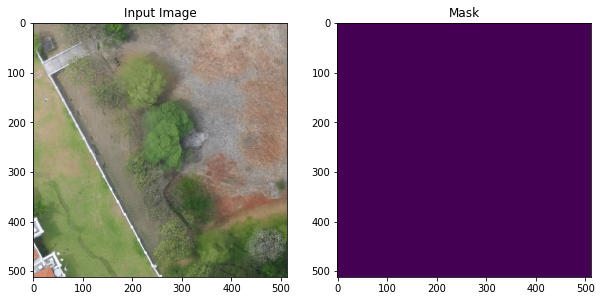

In [21]:
plotting_utils.display_from_path(df.loc[0,'img_path'])

I do not want to include image as above because mask contains only one class. Looks like it is mislabelled.
I decided to take pictures with the ratio of pixels between 0.05 and 0.99 plus I add 600 samples with ratio being 0 (those must be in the test set as well so that the model sees some examples).

In [0]:
df_good = df[(df.object_pixels_ratio >= 0.05) &
             (df.object_pixels_ratio < 1)
             ].head(3000)
df_zeroes = df[df.object_pixels_ratio == 0].head(3000)
df_final = pd.concat([df_good, df_zeroes], ignore_index=True)

Quite a lot of pictures without any object. For model training I take all the pictures with any object plus 100 empty images.

In [23]:
df_final.head(5)

img_path  ... object_pixels_ratio
0  opencities/data/images-256/acc_665946_260_19_2...  ...            0.988434
1  opencities/data/images-256/dar_0a4c40_820_19_3...  ...            0.968472
2  opencities/data/images-256/dar_0a4c40_657_19_3...  ...            0.962872
3  opencities/data/images-256/dar_0a4c40_699_19_3...  ...            0.945488
4  opencities/data/images-256/acc_665946_102_19_2...  ...            0.880428

[5 rows x 5 columns]

In [24]:
df_final.tail(5)

img_path  ... object_pixels_ratio
5995  opencities/data/images-256/znz_bd5c14_821_19_3...  ...                 0.0
5996  opencities/data/images-256/znz_425403_1015_19_...  ...                 0.0
5997  opencities/data/images-256/znz_c7415c_258_19_3...  ...                 0.0
5998  opencities/data/images-256/znz_e52478_135_19_3...  ...                 0.0
5999  opencities/data/images-256/znz_076995_1219_19_...  ...                 0.0

[5 rows x 5 columns]

In [25]:
df_final.shape

(6000, 5)

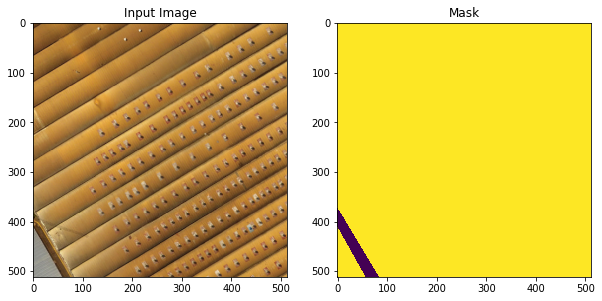

In [26]:
plotting_utils.display_from_path(df_final.loc[0,'img_path'])

# **Preprocess data**

In [0]:
BATCH_SIZE = 6
BUFFER_SIZE = 15
IMG_DIMS = (512, 512)

In [0]:
train_df, valid_df, test_df = split_df.split_df(df_final, test_size=0.3)

In [29]:
train_df.shape, valid_df.shape, test_df.shape

((4200, 5), (900, 5), (900, 5))

In [0]:
train = read_imgs_from_df(train_df, IMG_DIMS)
valid = read_imgs_from_df(valid_df, IMG_DIMS)
test = read_imgs_from_df(test_df, IMG_DIMS)

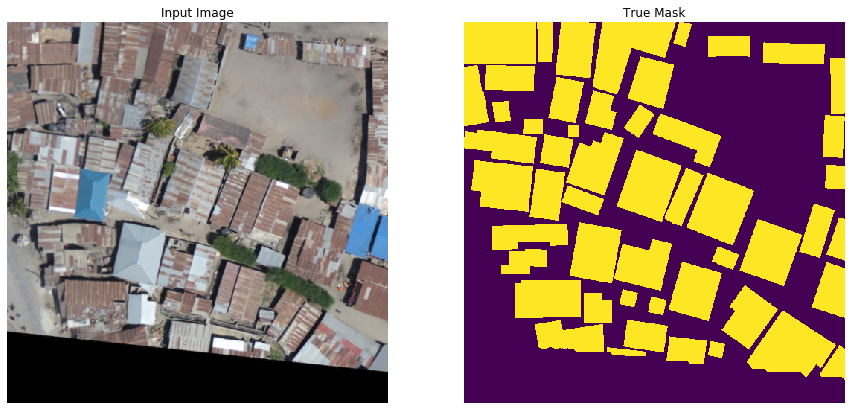

In [31]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
plotting_utils.display_array([sample_image, sample_mask])

In [32]:
np.unique(sample_mask.numpy().flatten())

array([0., 1.], dtype=float32)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = valid.batch(BATCH_SIZE)
test_dataset = test.batch(BATCH_SIZE)

# **Define the models**

In [0]:
LEARNING_RATE = 1e-4
EPOCHS = 8
TRAIN_FROM_SCRATCH = False

**1. Vanilla Unet**

In [0]:
MODEL_NAME_1 = 'vanilla_unet'+str(date.today())+'.h5'
MODEL_TO_LOAD_1 = 'vanilla_unet2020-02-28.h5'

In [0]:
inputs = Input(IMG_DIMS+(3,))

In [0]:
if TRAIN_FROM_SCRATCH:
  basic_unet = vanilla_unet.make_unet(inputs, n_filters=16, dropout=False, batchnorm=True)
  basic_unet.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss="binary_crossentropy", 
    metrics=["accuracy"])
  basic_unet._name = MODEL_NAME_1
else:
  basic_unet = tf.keras.models.load_model(MODEL_TO_LOAD_1)

In [38]:
basic_unet.summary()

Model: "vanilla_unet2020-02-28.h5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
__________________________________________________________________________

In [0]:
if TRAIN_FROM_SCRATCH:
  basic_unet.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    verbose=1,
    steps_per_epoch=math.ceil(train_df.shape[0]/BATCH_SIZE),
    validation_steps=math.ceil(valid_df.shape[0]/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[
               tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=max(2, EPOCHS//4)), 
               tf.keras.callbacks.EarlyStopping(
                   patience=max(2, EPOCHS // 4)*2, restore_best_weights=True), 
               tf.keras.callbacks.ModelCheckpoint(
                   MODEL_NAME_1, monitor='val_loss', verbose=0, 
                   save_best_only=True,)
               ]
  )

In [0]:
if TRAIN_FROM_SCRATCH:
  files.download(MODEL_NAME_1)

**2. Unet with dropout**

In [0]:
MODEL_NAME_2 = 'unet_with_dropout'+str(date.today())+'.h5'
MODEL_TO_LOAD_2 = 'unet_with_dropout2020-02-28.h5'

In [0]:
if TRAIN_FROM_SCRATCH:
  unet_with_dropout = vanilla_unet.make_unet(
    inputs, n_filters=16, dropout=0.1, batchnorm=True)
  unet_with_dropout.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss="binary_crossentropy", 
    metrics=["accuracy"])
  unet_with_dropout._name = MODEL_NAME_2
else:
  unet_with_dropout = tf.keras.models.load_model(MODEL_TO_LOAD_2)

In [0]:
if TRAIN_FROM_SCRATCH:
  unet_with_dropout.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    verbose=1,
    steps_per_epoch=math.ceil(train_df.shape[0]/BATCH_SIZE),
    validation_steps=math.ceil(valid_df.shape[0]/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[
               tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=max(2, EPOCHS//4)), 
               tf.keras.callbacks.EarlyStopping(
                   patience=max(2, EPOCHS // 4)*2, restore_best_weights=True), 
               tf.keras.callbacks.ModelCheckpoint(
                   MODEL_NAME_2, monitor='val_loss', verbose=0, 
                   save_best_only=True,)
               ]
  )

In [0]:
if TRAIN_FROM_SCRATCH:
  files.download(MODEL_NAME_2)

**3. Define custom objective function for training**

Define Jaccard function smilar to here: https://github.com/ZFTurbo/ZF_UNET_224_Pretrained_Model/blob/master/zf_unet_224_model.py

In [0]:
def jacard_coef(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (tf.keras.backend.sum(y_true_f) \
                                   + tf.keras.backend.sum(y_pred_f) - intersection + 1.0)

In [0]:
def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [0]:
MODEL_NAME_3 = 'unet_jaccard'+str(date.today())+'.h5'
MODEL_TO_LOAD_3 = 'unet_jaccard2020-02-29.h5'

In [0]:
if TRAIN_FROM_SCRATCH:
  unet_jaccard = vanilla_unet.make_unet(inputs, n_filters=16, dropout=False, batchnorm=True)
  unet_jaccard.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=[jacard_coef_loss], 
    metrics=["accuracy", jacard_coef])
  unet_jaccard._name = MODEL_NAME_3
else:
  unet_jaccard = tf.keras.models.load_model(MODEL_TO_LOAD_3, compile=False)
  unet_jaccard.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss=[jacard_coef_loss], 
    metrics=["accuracy", jacard_coef])

In [0]:
if TRAIN_FROM_SCRATCH:
  unet_jaccard.fit(
    x=train_dataset,
    validation_data=validation_dataset,
    verbose=1,
    steps_per_epoch=math.ceil(train_df.shape[0]/BATCH_SIZE),
    validation_steps=math.ceil(valid_df.shape[0]/BATCH_SIZE),
    epochs=EPOCHS,
    callbacks=[
               tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=max(2, EPOCHS//4)), 
               tf.keras.callbacks.EarlyStopping(
                   patience=max(2, EPOCHS // 4)*2, restore_best_weights=True), 
               tf.keras.callbacks.ModelCheckpoint(
                   MODEL_NAME_3, monitor='val_jacard_coef', verbose=0, 
                   save_best_only=True,)
               ]
  )

In [0]:
if TRAIN_FROM_SCRATCH:
  files.download(MODEL_NAME_3)

**Check models**

In [52]:
basic_unet.evaluate(test_dataset)

150/150 [==============================] - 35s 231ms/step - loss: 0.2063 - accuracy: 0.9132


[0.20628500369687874, 0.91318804]

In [53]:
unet_with_dropout.evaluate(test_dataset)

150/150 [==============================] - 27s 179ms/step - loss: 0.2084 - accuracy: 0.9137


[0.20840451337397098, 0.9137038]

In [54]:
unet_jaccard.evaluate(test_dataset)

150/150 [==============================] - 27s 178ms/step - loss: -0.5271 - accuracy: 0.8724 - jacard_coef: 0.5271


[-0.5270841167373995, 0.87242013, 0.527084]

In [0]:
def plot_results(model):
  for images, masks in test_dataset.take(1):
    predictions = np.where(basic_unet.predict(images)>0.5,1,0)
    for img, mask, pred in zip(images, masks, predictions):
      plotting_utils.display_array([img, mask, pred])

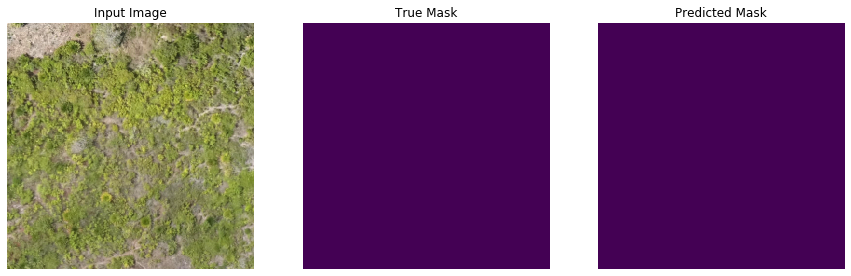

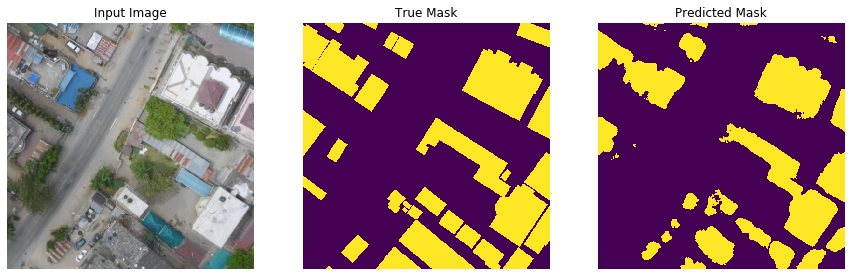

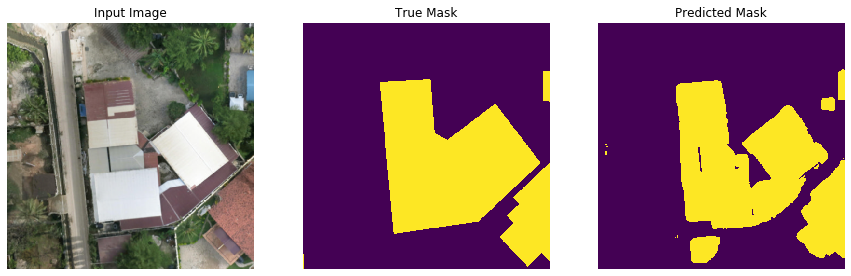

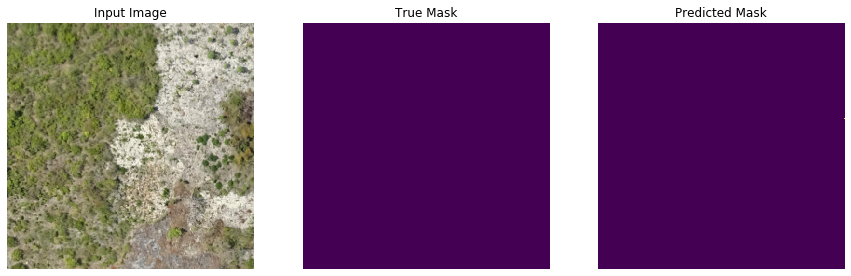

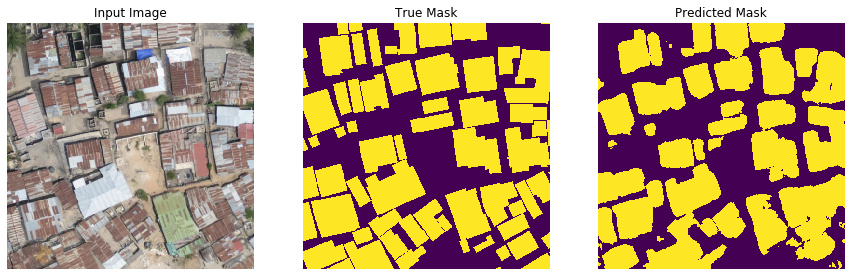

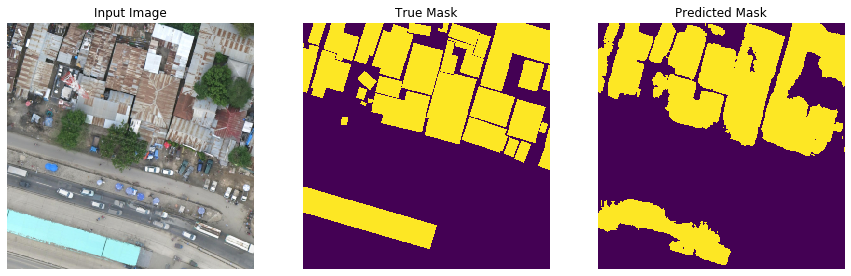

In [56]:
plot_results(basic_unet)

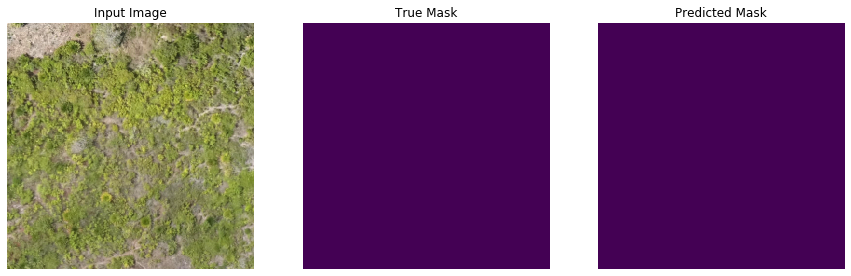

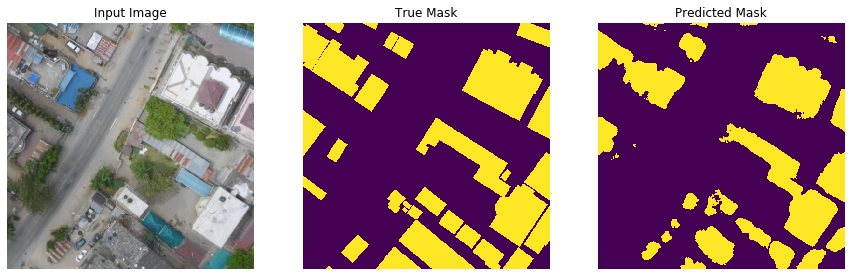

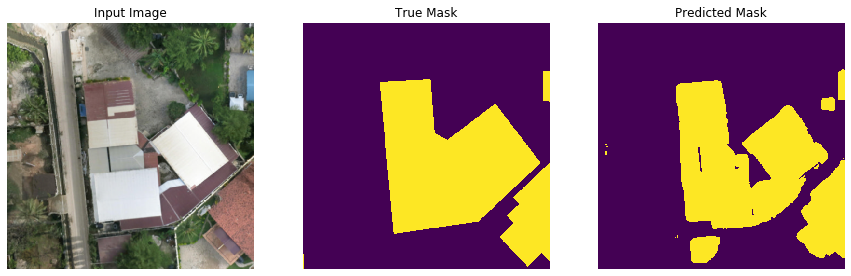

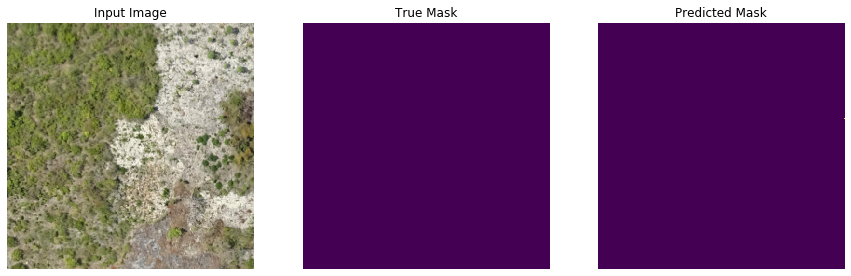

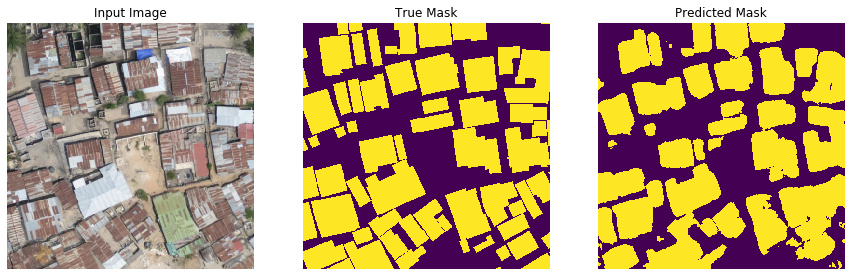

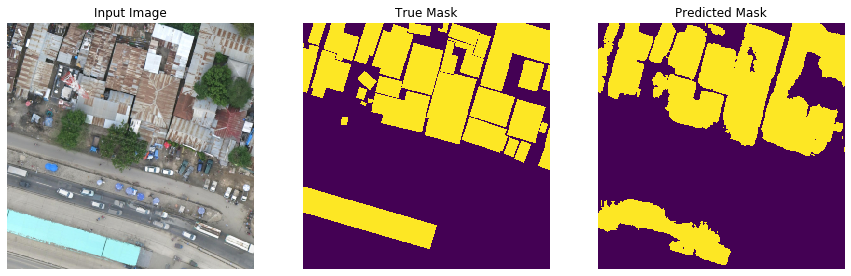

In [57]:
plot_results(unet_with_dropout)

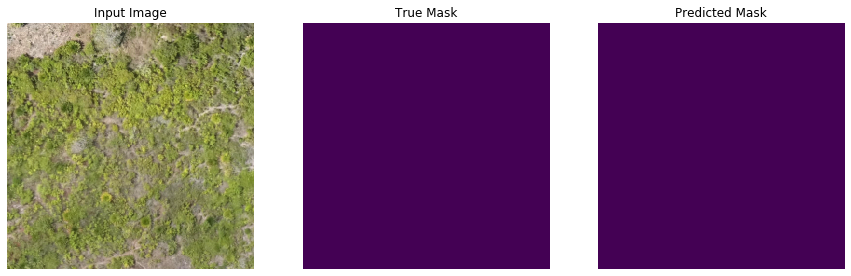

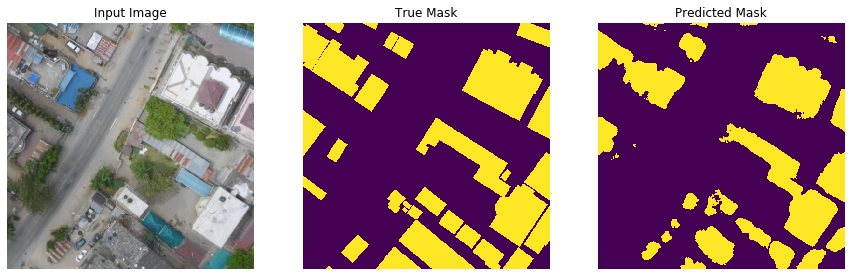

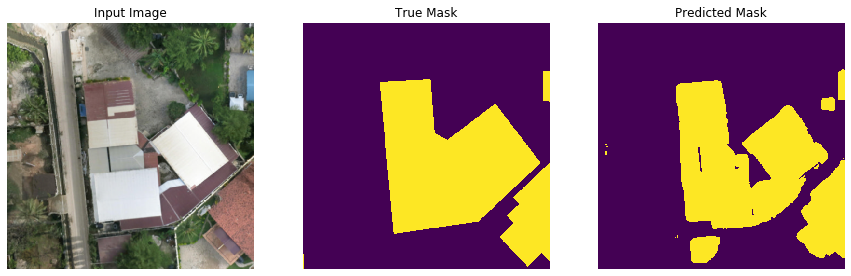

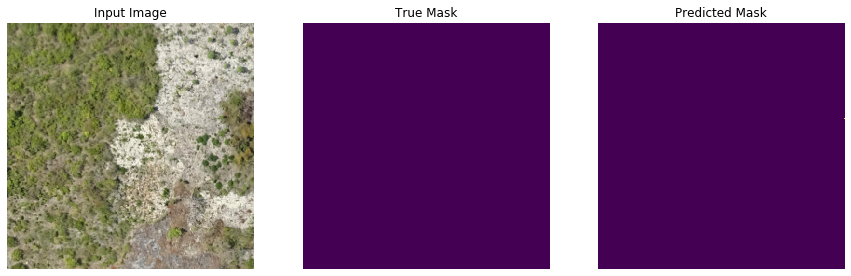

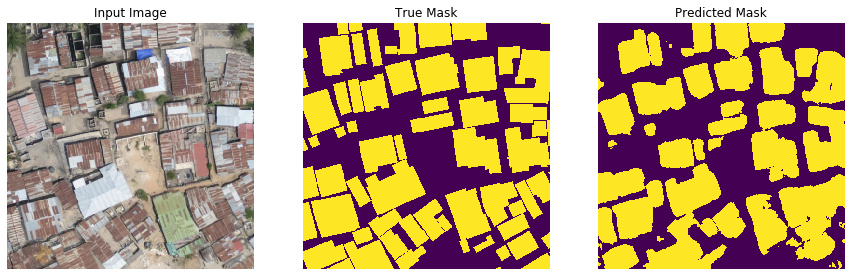

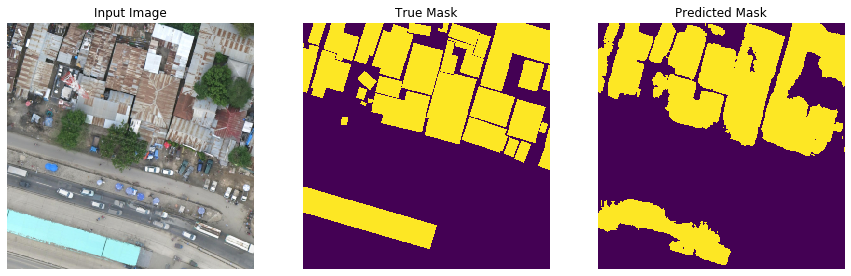

In [58]:
plot_results(unet_jaccard)

# **Prepare submission**

In [0]:
!wget https://drivendata-public-assets.s3.amazonaws.com/test.tgz

In [0]:
!tar -xvf test.tgz

In [0]:
test_lst = glob('test/*/*.tif')

In [0]:
len(test_lst)

In [0]:
test_df = pd.DataFrame({
    'img_path':test_lst,
    'id':[t.split('/')[1] for t in test_lst]
})

In [0]:
test_df.shape

In [0]:
test_df.head(5)

In [0]:
def plot_test_results(model):
  for idx, row in test_df.head(10).iterrows():
    img_path = row.img_path
    img = np.array(PImage.open(img_path))[:,:,:3]
    img_ready = load_img.normalize(
        (load_img.img_resize(img, IMG_DIMS)))
    img_expanded = np.expand_dims(img_ready, axis=0)
    pred = np.where(model.predict(img_expanded)>0.5,1,0)[-1]
    plotting_utils.display_array([img, pred])

In [0]:
plot_test_results(basic_unet)

In [0]:
plot_test_results(unet_with_dropout)

In [0]:
plot_test_results(unet_jaccard)

In [0]:
!rm -rf test.tgz
!rm -rf opencities

In [0]:
#!rm -rf test

In [0]:
def prepare_submission(df, model):
  sub_dir = Path('submissions/'+str(model.name)[:-3])
  if os.path.exists(str(sub_dir)):
    shutil.rmtree(str(sub_dir))
  sub_dir.mkdir(parents=True, exist_ok=True)
  for idx, row in tqdm_notebook(df.iterrows()):
    img_id = row.id
    img_path = row.img_path
    img = np.array(PImage.open(img_path))[:,:,:3]
    img_ready = load_img.normalize(
        (load_img.img_resize(img, IMG_DIMS)))
    img_expanded = np.expand_dims(img_ready, axis=0)
    pred = np.where(model.predict(img_expanded)>0.5,1,0)
    pred_resized = tf.image.resize(pred, (1024,1024), method='nearest')
    im = PImage.fromarray(np.array(pred_resized).astype(np.uint8).reshape(1024,1024))
    im.save(str(sub_dir)+'/'+str(img_id)+'.TIFF', compression='tiff_deflate')


In [0]:
prepare_submission(test_df, basic_unet)

In [0]:
  %cd ./submissions/vanilla_unet2020-03-04
  !zip -r ../vanilla.zip . -q

In [0]:
if False:
  prepare_submission(test_df, unet_with_dropout)
  %cd ./submissions/vanilla_unet2020-02-28
  !zip -r ../vanilla_unet.zip . -q

In [0]:
if True:
  prepare_submission(test_df, unet_jaccard)
  %cd ./submissions/unet_jaccard2020-02-29
  !zip -r ../unet_jaccard.zip . -q

In [0]:
!pwd

In [0]:
%cd ../..